In [43]:
import gym
from gym import spaces
import robo_gym
from robo_gym.wrappers.exception_handling import ExceptionHandling
import numpy as np
import pfrl
import torch
from torch import distributions, nn
import matplotlib.pyplot as plt
from collections import deque

In [44]:
class WrapPyTorch(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(WrapPyTorch, self).__init__(env)
        self.prior_count = 2
        self.prior_stack = deque(maxlen=self.prior_count)
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.prior_count, env.map_size, env.map_size,), dtype=np.float32)
        
    def observation(self, observation):
        if len(self.prior_stack) == self.prior_count:
            self.prior_stack.append(observation)
        else:
            self.prior_stack.extend([observation for _ in range(self.prior_count)])
        return np.array(self.prior_stack)

    def reset(self, **kwargs):
        self.prior_stack.clear()
        return self.observation(self.env.reset(**kwargs))

In [45]:
target_machine_ip = 'robot-server' # or other machine 'xxx.xxx.xxx.xxx'

# initialize environment
env = gym.make('CubeSearchInCubeRoomObsMapOnly-v0', ip=target_machine_ip, gui=True, gazebo_gui=True)
env = ExceptionHandling(env)
env = WrapPyTorch(env)

Starting new Robot Server | Tentative 1 of 10
Successfully started Robot Server at 10.244.6.5:54321
Resetting env... [room: True, pose: True]
[[[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]]


In [56]:
state = env.reset(
    new_room=True,
    new_agent_pose=True,
    obstacle_count=32,
    room_length_max=12.0,
    room_mass_min=110.0,
    room_mass_max=150.0,
)
print(state)

Resetting env... [room: True, pose: True]
[[[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]]


In [57]:
timestep_limit = env.spec.max_episode_steps
obs_space = env.observation_space
action_space = env.action_space
obs_size = obs_space.low.size
action_size = action_space.low.size
prior_observation_count = env.prior_count

print(f'timelimit: \t{timestep_limit}')
print(f'obs_space: \t{obs_space} \naction_space: \t{action_space}')
print(f'obs_size: \t{obs_size}')
print(f'action_size: \t{action_size}')
print(f'prior_observation_count: \t{prior_observation_count}')

timelimit: 	500
obs_space: 	Box(-1.0, 100.0, (1, 128, 128), float32) 
action_space: 	Box(-1.0, 1.0, (3,), float32)
obs_size: 	16384
action_size: 	3


In [58]:
def conv2d_size_out(size, kernel_size=5, stride=2):
    return (size - (kernel_size - 1) - 1) // stride + 1
        
def make_conv2d_layer(channel, width, height):
    convW = conv2d_size_out(width, 8, 4) # 128 -> 31
    convW = conv2d_size_out(convW, 4, 3) # 31 -> 10
    convW = conv2d_size_out(convW, 4, 3) # 10 -> 3

    convH = conv2d_size_out(height, 8, 4)
    convH = conv2d_size_out(convH, 4, 3)
    convH = conv2d_size_out(convH, 4, 3)

    linear_input_size = convW * convH * 64
    print('size:', linear_input_size)

    # RGB Image tensor as input
    net = nn.Sequential(
        nn.Conv2d(channel, 32, kernel_size=8,stride=4),
        nn.ELU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=3),
        nn.ELU(),
        nn.Conv2d(64, 64, kernel_size=4,stride=3),
        nn.ELU(),
        nn.Flatten(),
    )
    nn.init.xavier_uniform_(net[0].weight, gain=torch.nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(net[2].weight, gain=torch.nn.init.calculate_gain('relu'))
    nn.init.xavier_uniform_(net[4].weight, gain=torch.nn.init.calculate_gain('relu'))
    return net, linear_input_size

def make_linear_layer(linear_input_size, out_size):
    net = nn.Sequential(
        nn.Linear(linear_input_size, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, out_size),
    )
    torch.nn.init.xavier_uniform_(net[0].weight, gain=torch.nn.init.calculate_gain('relu'))
    torch.nn.init.xavier_uniform_(net[2].weight, gain=torch.nn.init.calculate_gain('relu'))
    torch.nn.init.xavier_uniform_(net[4].weight, gain=torch.nn.init.calculate_gain('relu'))
    return net

In [59]:
def squashed_diagonal_gaussian_head(x):
    assert x.shape[-1] == action_size * 2
    mean, log_scale = torch.chunk(x, 2, dim=1)
    log_scale = torch.clamp(log_scale, -20.0, 2.0)
    var = torch.exp(log_scale * 2)
    base_distribution = distributions.Independent(
        distributions.Normal(loc=mean, scale=torch.sqrt(var)), 1
    )
    # cache_size=1 is required for numerical stability
    return distributions.transformed_distribution.TransformedDistribution(
        base_distribution, [distributions.transforms.TanhTransform(cache_size=1)]
    )

In [60]:
class PolicyFunction(nn.Module):
    def __init__(self, channel, width, height, action_size):
        super().__init__()
        # RGB Image tensor as input
        self.selectTrackFeatures, self.linear_input_size = make_conv2d_layer(channel, width, height)
        self.fc1 = make_linear_layer(self.linear_input_size, action_size*2)
    
    def forward(self, state):
        x = self.selectTrackFeatures(state)
        x = self.fc1(x)
        return squashed_diagonal_gaussian_head(x)

obs_map_shape = obs_space.low.shape
print(obs_map_shape)
policy = PolicyFunction(prior_observation_count, obs_map_shape[1], obs_map_shape[2], action_size)
policy_optimizer = torch.optim.Adam(policy.parameters(), lr=3e-4)

(1, 128, 128)
size: 2304


In [61]:
class QFunction(nn.Module):
    def __init__(self, channel, width, height, action_size):
        super().__init__()

        # RGB Image tensor as input
        self.selectTrackFeatures, self.linear_input_size = make_conv2d_layer(channel, width, height)
        self.fc1 = make_linear_layer(self.linear_input_size + action_size, 1)
    
    def forward(self, state_and_action):
        state = state_and_action[0]
        occupancy_vector = self.selectTrackFeatures(state)
        x = torch.cat((occupancy_vector, state_and_action[1]), axis=-1)
        return self.fc1(x)

q_func1 = QFunction(prior_observation_count, obs_map_shape[1], obs_map_shape[2], action_size)
q_func2 = QFunction(prior_observation_count, obs_map_shape[1], obs_map_shape[2], action_size)
q_func1_optimizer = torch.optim.Adam(q_func1.parameters(), lr=3e-4)
q_func2_optimizer = torch.optim.Adam(q_func2.parameters(), lr=3e-4)

size: 2304
size: 2304


In [62]:
rbuf = pfrl.replay_buffers.ReplayBuffer(10 ** 6)

In [63]:
def burnin_action_func():
    """Select random actions until model is updated one or more times."""
    return np.random.uniform(action_space.low, action_space.high).astype(np.float32)

In [64]:
gamma = 0.99
replay_start_size = 10000
gpu = 0
batch_size = 256
entropy_target = -action_size
temperature_optimizer_lr = 3e-3

agent = pfrl.agents.SoftActorCritic(
    policy,
    q_func1,
    q_func2,
    policy_optimizer,
    q_func1_optimizer,
    q_func2_optimizer,
    rbuf,
    gamma=gamma,
    replay_start_size=replay_start_size,
    gpu=gpu,
    minibatch_size=batch_size,
    burnin_action_func=burnin_action_func,
    entropy_target=entropy_target,
    temperature_optimizer_lr=temperature_optimizer_lr,
)

Resetting env... [room: False, pose: False]


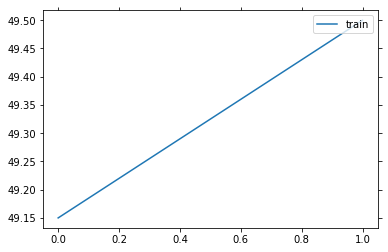

Resetting env... [room: False, pose: False]
Resetting env... [room: False, pose: False]


In [ ]:
from fastprogress import master_bar, progress_bar

n_episodes = 1000
max_episode_len = 25
eval_step = 10
total_R = 0

reward_traj = []
mb = master_bar(range(n_episodes))

for i in mb:
    obs = env.reset(new_room=False, new_agent_pose=False)
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        # print(f"action: {action}, reward: {reward}")
        if done or reset:
            break
            
    x = np.arange(i+1)
    reward_traj.append(R)
    mb.update_graph([[x,reward_traj]])
            
    total_R += R
    if i % eval_step == 0:
        with open('train.txt', 'a') as f:
            f.write(f'episode: {i}, R_mean: {total_R/eval_step} \nstatistics: {agent.get_statistics()}\n')
        total_R = 0

print('Finished')

In [18]:
agent.get_statistics()

[('average_q1', 46.492405),
 ('average_q2', 46.671005),
 ('average_q_func1_loss', 7.136345384120941),
 ('average_q_func2_loss', 7.319724645614624),
 ('n_updates', 40001),
 ('average_entropy', -3.0528266),
 ('temperature', 0.02014336548745632)]

## Inspection

In [22]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

eval_count = 30
target_pose = env.target_pose # (n,3)
obs_map_size = env.observation_space.low.size
obs_map_len = int(np.sqrt(obs_map_size))

### Random Policy

In [ ]:
logging.info("Start evaluating random policy.")

rewards = np.zeros([eval_count, max_episode_len])
founds = np.zeros([eval_count, env.target_num])
states = []
agent_trajectories = np.zeros([eval_count, max_episode_len, 3])
goal_trajectories = np.zeros([eval_count, max_episode_len, 3])
start_agent_poses = np.zeros([eval_count, 3])
start_maps = np.zeros([eval_count, obs_map_len, obs_map_len])

for e in range(eval_count):
    obs = env.reset(new_room=False, new_agent_pose=True)
    start_agent_poses[e] = env.agent_pose
    start_maps[e] = obs[0]
    done = False
    step = 0
    while (not done) and (step < max_episode_len):
        action = env.action_space.sample()
        obs, r, done, _ = env.step(action)
        states.append(obs)
        rewards[e,step] = r
        agent_trajectories[e,step] = env.agent_pose
        goal_trajectories[e,step] = env.goal_pose
        step += 1
        
    founds[e] = env.target_found
            

INFO:root:Start evaluating random policy.


Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]
Resetting env... [room: False, pose: True]


In [29]:
found_probs = [np.sum(founds[:,f])/eval_count for f in range(len(founds[0]))]
total_reward_mean = sum([np.sum(rewards[i]) for i in range(eval_count)]) / eval_count

print(f'target found probability: {found_probs}')
print(f'total reward mean: {total_reward_mean}')

target found probability: [0.025, 0.0, 0.3, 0.0, 0.15, 0.025, 0.0, 0.1, 0.1, 0.025, 0.0, 0.175, 0.025, 0.25, 0.0, 0.125, 0.025, 0.0, 0.05, 0.1, 0.0, 0.2, 0.0, 0.025, 0.05, 0.075]
total reward mean: 89.77250000000001


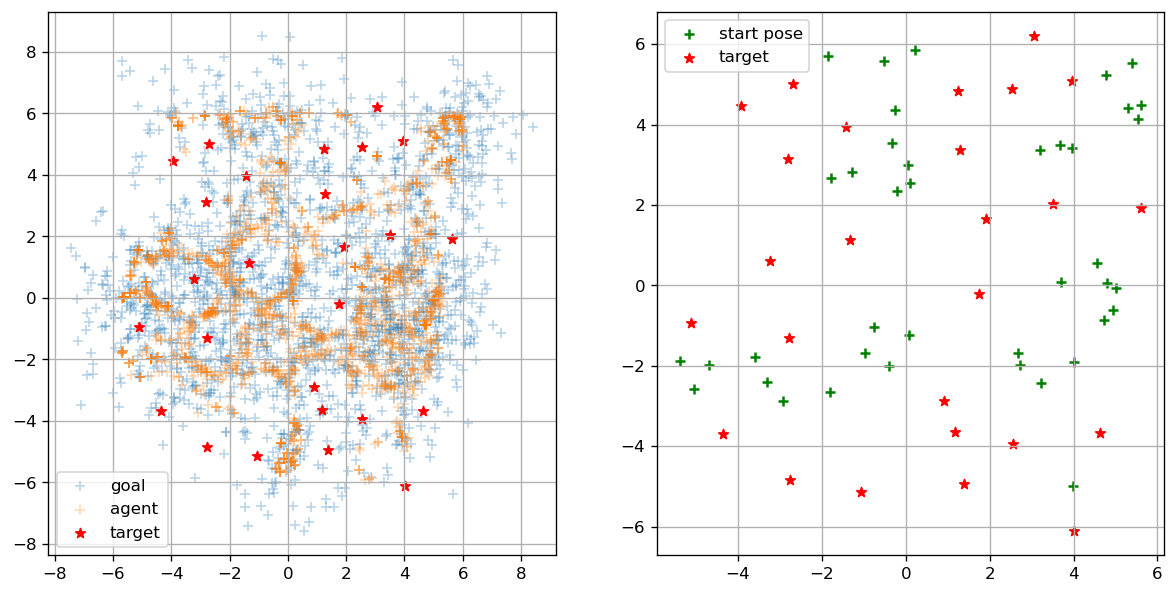

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=120)

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(goal_trajectories[:,:,0], goal_trajectories[:,:,1], marker='+', alpha=0.3, linewidths=1, label='goal')
plt.scatter(agent_trajectories[:,:,0], agent_trajectories[:,:,1], marker='+', alpha=0.3, linewidths=1,  label='agent')
plt.scatter(target_pose[:,0], target_pose[:,1], c='red', marker='*', label='target')
plt.legend()

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(start_agent_poses[:,0], start_agent_poses[:,1], c='green', marker='+', label='start pose')
plt.scatter(target_pose[:,0], target_pose[:,1], c='red', marker='*', label='target')
plt.legend()

### Trained Policy

In [ ]:
logging.info("Start evaluating traind policy.")

t_rewards = np.zeros([eval_count, max_episode_len])
t_founds = np.zeros([eval_count, env.target_num])
t_states = []
t_agent_trajectories = np.zeros([eval_count, max_episode_len, 3])
t_goal_trajectories = np.zeros([eval_count, max_episode_len, 3])
t_start_agent_poses = np.zeros([eval_count, 3])
t_start_maps = np.zeros([eval_count, obs_map_len, obs_map_len])

with agent.eval_mode():
    for e in range(eval_count):
        obs = env.reset(new_room=False, new_agent_pose=True)
        t_start_agent_poses[e] = env.agent_pose
        t_start_maps[e] = obs[0]
        done = False
        step = 0
        while (not done) and (step < max_episode_len):
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            t_states.append(obs)
            t_rewards[e,step] = r
            t_agent_trajectories[e,step] = env.agent_pose
            t_goal_trajectories[e,step] = env.goal_pose
            step += 1
            
        logging.info(f'current episode\'s total reward: {np.sum(t_rewards[e])}')
        t_founds[e] = env.target_found

In [ ]:
t_found_probs = [np.sum(t_founds[:,f])/eval_count for f in range(len(t_founds[0]))]
t_total_reward_mean = sum([np.sum(t_rewards[i]) for i in range(eval_count)]) / eval_count

print(f'target found probability: {t_found_probs}')
print(f'total reward mean: {t_total_reward_mean}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=120)

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(t_goal_trajectories[:,:,0], t_goal_trajectories[:,:,1], marker='+', alpha=0.3, linewidths=1, label='goal')
plt.scatter(t_agent_trajectories[:,:,0], t_agent_trajectories[:,:,1], marker='+', alpha=0.3, linewidths=1,  label='agent')
plt.scatter(target_pose[:,0], target_pose[:,1], c='red', marker='*', label='target')
plt.legend()

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(t_start_agent_poses[:,0], t_start_agent_poses[:,1], c='green', marker='+', label='start pose')
plt.scatter(target_pose[:,0], target_pose[:,1], c='red', marker='*', label='target')
plt.legend()

In [40]:
rbuf.save('./rbuf')

In [39]:
agent.save('./agent')